## Building Your First LangGraph

Now that we understand the building blocks, let’s put them into practice by building our first functional graph. We’ll implement Alfred’s email processing system, where he needs to:

1. Read incoming emails
2. Classify them as spam or legitimate
3. Draft a preliminary response for legitimate emails
4. Send information to Mr. Wayne when legitimate (printing only)


This example demonstrates how to structure a workflow with LangGraph that involves LLM-based decision-making. While this can’t be considered an Agent as no tool is involved, this section focuses more on learning the LangGraph framework than Agents.

Here is the workflow we will build:

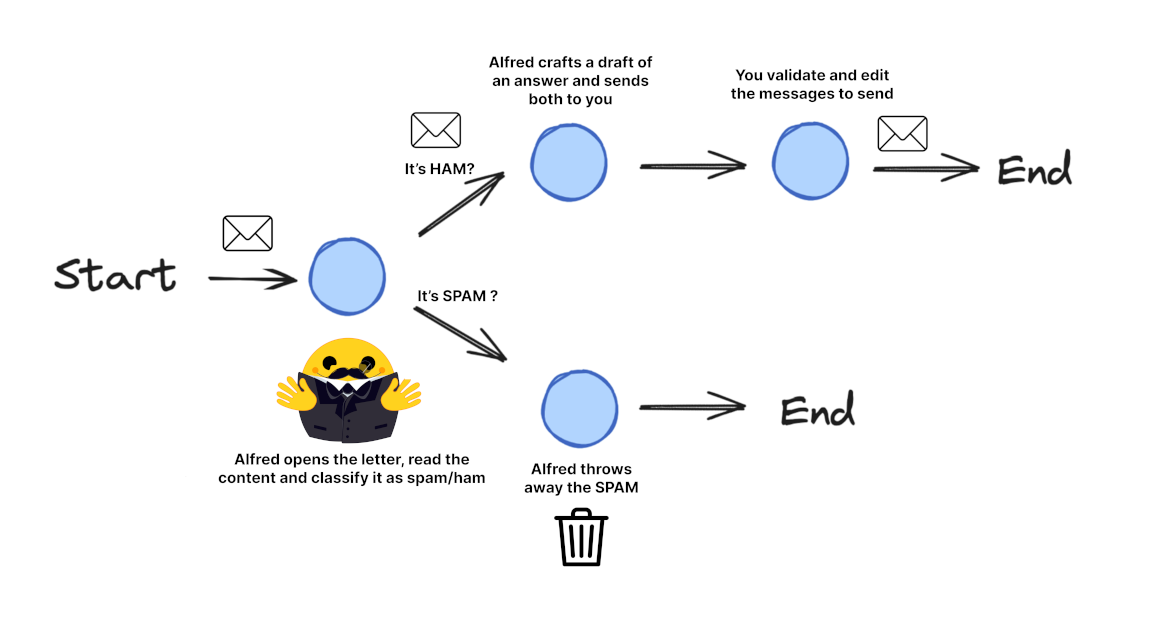

In [1]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage

Set up tracing:

In [7]:
import os
import base64
from dotenv import load_dotenv
load_dotenv()

LANGFUSE_PUBLIC_KEY=os.environ.get('LANGFUSE_PUBLIC_KEY')
LANGFUSE_SECRET_KEY=os.environ.get("LANGFUSE_PUBLIC_KEY")
LANGFUSE_AUTH=base64.b64encode(f"{LANGFUSE_PUBLIC_KEY}:{LANGFUSE_SECRET_KEY}".encode()).decode()

os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = "https://cloud.langfuse.com/api/public/otel" # EU data region
# os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = "https://us.cloud.langfuse.com/api/public/otel" # US data region
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"Authorization=Basic {LANGFUSE_AUTH}"

Then, we configure the Langfuse callback_handler and instrument the agent by adding the langfuse_callback to the invocation of the graph: config={"callbacks": [langfuse_handler]}.

In [11]:
class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    ## Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Analysis and decision
    is_spam: Optional[bool]

    # Response generation
    email_draft: Optional[str]

    # Processing metadata
    messages: List[Dict[str, Any]]

<i>"💡 Tip: Make your state comprehensive enough to track all the important information, but avoid bloating it with unnecessary details."</i>

### Step 2: Define Our Nodes

Now, let's create the processing functions that will form our nodes

In [26]:
model = ChatOllama(model="gemini-3-flash-preview:cloud")

Test run

In [27]:
messages = [
    ("human", "How are you")
]

model.invoke(messages)

AIMessage(content="I'm doing well, thank you for asking! How are you doing today? Is there anything I can help you with?", additional_kwargs={}, response_metadata={'model': 'gemini-3-flash-preview:cloud', 'created_at': '2026-01-14T11:21:14.39875796Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2900864976, 'load_duration': None, 'prompt_eval_count': 4, 'prompt_eval_duration': None, 'eval_count': 301, 'eval_duration': None, 'logprobs': None, 'model_name': 'gemini-3-flash-preview:cloud', 'model_provider': 'ollama'}, id='lc_run--019bbc3c-f9df-70a1-ad0c-420eedb8027c-0', usage_metadata={'input_tokens': 4, 'output_tokens': 301, 'total_tokens': 305})

In [28]:
def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]

    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")

    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text
    
    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "email_draft": response.content,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")
    
    # We're done processing this email
    return {}

### Step 3: Define Our Routing Logic

We need a function to determine which path to take after classification:

In [29]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification."""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

<i>💡 Note: This routing function is called by LangGraph to determine which edge to follow after the classification node. The return value must match one of the keys in our conditional edges mapping.</i>

### Step 4: Create the StateGraph and Define Edges

Now we connect everything together

In [30]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)


# Start the edges
email_graph.add_edge(START, "read_email")

# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# compile the graph
compiled_graph = email_graph.compile()

Notice how we use the special END node provided by LangGraph. This indicates terminal states where the workflow completes.

### Step 5: Run the application

Let's test our graph with a legitimate email and a spam email:

In [31]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Very good, Master Hugg. I have taken the liberty of preparing a draft for your consideration. It acknowledges the referral and expresses a readiness to coordinate the requested call.

***

**Subject:** Re: Question about your services

Dear Mr. Smith,

Thank you for your inquiry. I was pleased to learn that a colleague referred you to my consulting services.

I would be very interested in discussing how I might be of assistance to you. Regarding your request for a call next week, I am currently finalizing my schedule. Would you be so kind as to share a few time slots that would be most convenient for you?

I look forward to our conversation.



Then, we configure the Langfuse callback_handler and instrument the agent by adding the langfuse_callback to the invocation of the graph: config={"callbacks": [langfuse_handler]}.

In [32]:
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

# Process legitimate email
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email, "is_spam": None, "spam_reason": None, "email_category": None, "draft_response": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Master Hugg,

A gentleman by the name of Mr. John Smith has sent an inquiry regarding your consulting services, noting that he was referred by one of your colleagues. 

I have taken the liberty of drafting a preliminary response for your review. Please let me know if it meets your requirements or if you wish for me to make any adjustments.

***

**Subject: RE: Question about your services**

Dear Mr. Smith,

Thank you for your inquiry. I was pleased to hear that you were referred by a colleague, and I appreciate your interest in my consulting services.

I would be happy to schedule a call next week to discuss how I might be of assistance. Please let me know a few dates and t

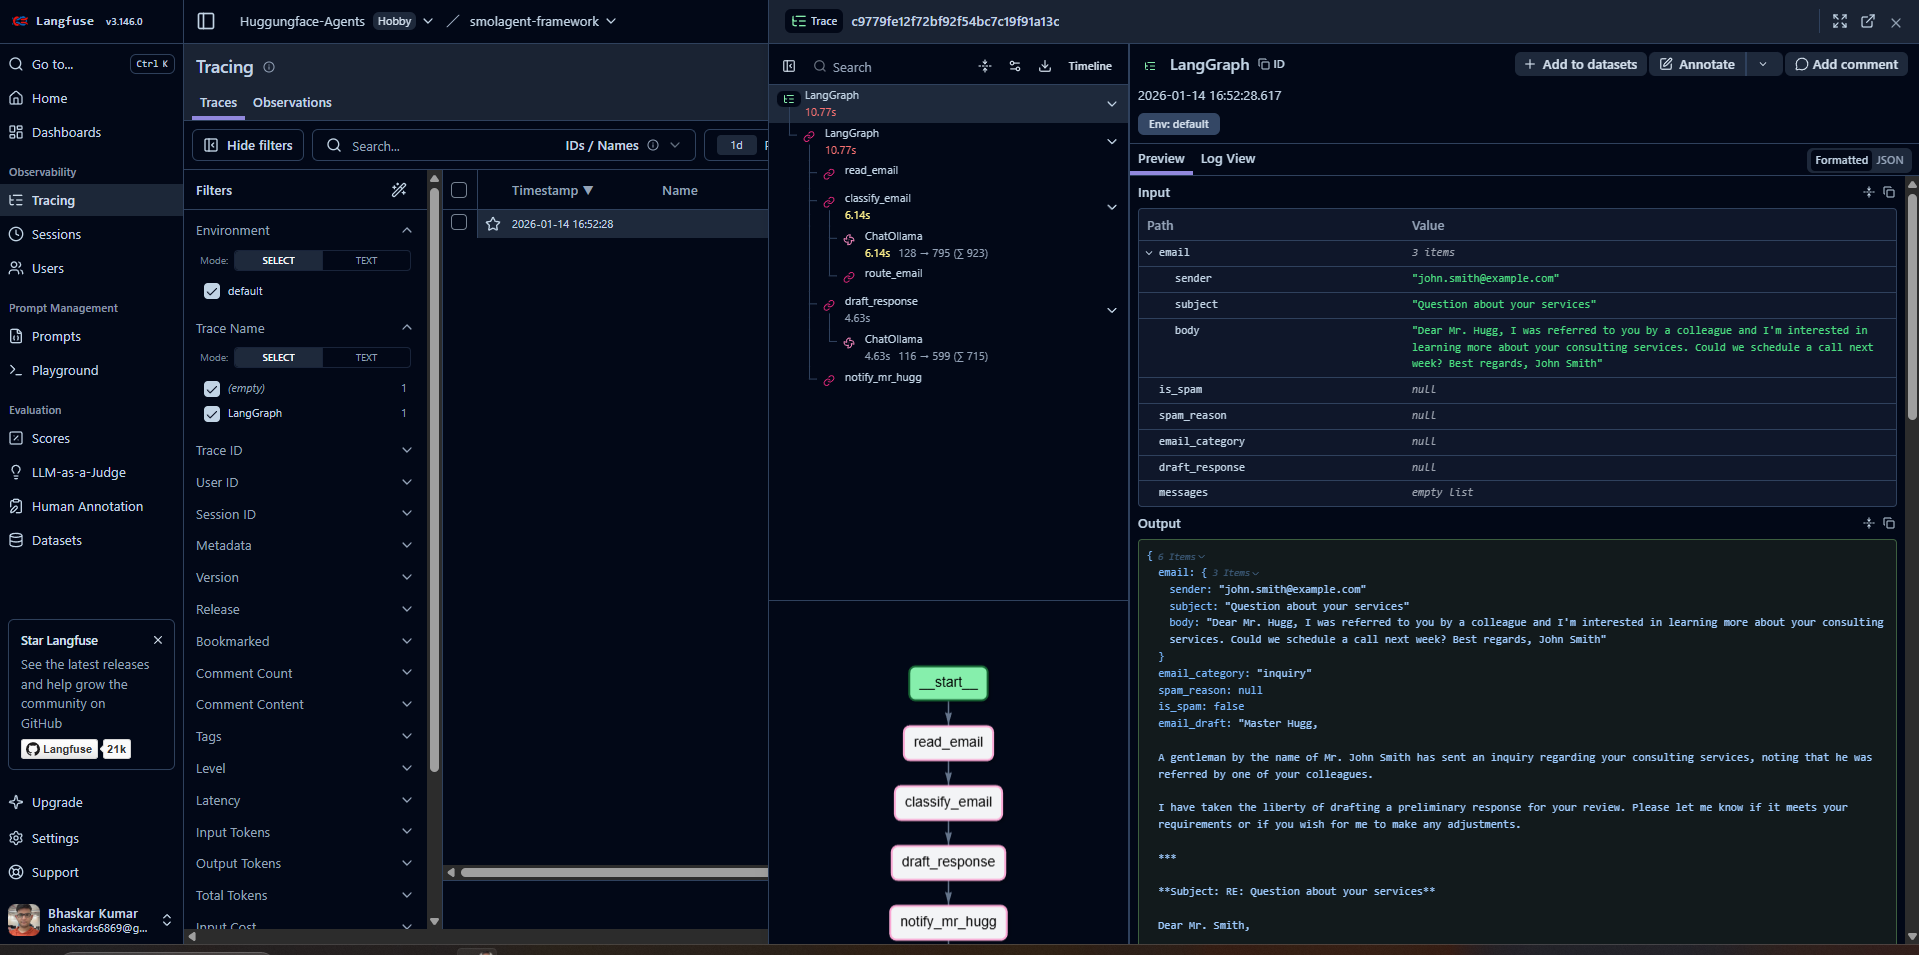

### Visualising our first graph

LangGraph allows us to visualize our workflow to better understand and debug its structure.

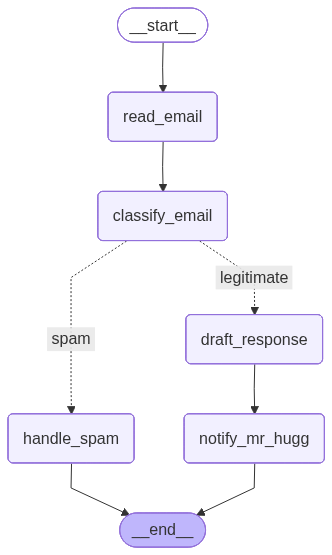

In [34]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

This produces a visual representation showing how our nodes are connected and the conditional paths that can be taken.